# Table of Contents
1. [Introduction](#intro)
2. [Setup](#setup_huh)
3. [Red vs White](#rvw)
   * [Predicting Wine Color](#rvw_prediction)
   * [Important Features for Wine Color](#rvw_feature_importance)
   * [Why Are These Features Important?](#rvw_feature_importance_why)
   * [Simplifying the Model](#rvw_simplified)
4. [Quality Prediction](#qp)
   * [Regression vs Classification](#qp_reg_vs_class)
      * [Issues with the Metric](#qp_issues_metric)
      * [Issues with Scoring](#qp_issues_scoring)
   * [Dataset Preparation](#qp_prep)
   * [Effective Degrees of Freedom](#qp_dof)
   * [Models Phase One - Algorithm Selection](#qp_models_p1)
   * [Models Phase Two - Feature Importance](#qp_models_p2)
      * [Dimensionality Reduction - Whites](#qp_dr_whites)
      * [Dimensionality Reduction - Reds](#qp_dr_reds)

<a id='intro'></a>
# Introduction
The wine quality dataset originated with the work of Paulo Cortez, who has made it available for download on [his website][1].  Dr. Cortez donated the dataset to the [UC Irvine Machine Learning Repository][2], and it has subsequently been uploaded to kaggle multiple times.

The original dataset consisted of two databases, one for red wines and another for whites. Some kagglers uploaded just the red wines; others just the whites. Sometimes they uploaded the full database; other times just a portion. One kaggler uploaded the combined databases, but unfortuantely replicated each record roughly 5 times. The following kagglers, however, appear to have uploaded a faithful representation of Dr. Cortez' original dataset, retaining both the red and white databases:
* [Shelvi Garg][3]
* [Dumindu Kavinda][4]
* [Rag Parmar][5]

In the current notebook, we focus on building the simplest machine learning model we can while still retaining a high level of predictivity. With the white wines, we found that the model could attain a 95% accuracy while using just three of the avaialble features, (```fixed acidity```, ```total sulfur dioxide```,```sulphates```).  With the red wines, we could attain that accuracy with just two features, (```alcohol```, ```density```).  In doing so, we did have to employ a ***slightly*** customized scoring methodology, as we felt that the out-of-the-box methodology was misleading for the problem at hand.  

Reference:<br>
<i>P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. [Modeling wine preferences by data mining from physicochemical properties][6]. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.</i>

[1]:https://pcortez.dsi.uminho.pt/
[2]:https://archive.ics.uci.edu/dataset/186/wine+quality
[3]:https://www.kaggle.com/datasets/shelvigarg/wine-quality-dataset
[4]:https://www.kaggle.com/datasets/greatdk/wine-quality-dataset/data
[5]:https://www.kaggle.com/datasets/rajyellow46/wine-quality
[6]:http://repositorium.sdum.uminho.pt/bitstream/1822/10029/1/wine5.pdf


<a id='setup_huh'></a>
# Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)

sns.set_theme()
RED_WINES = '/kaggle/input/wine-quality-dataset/winequality-red.csv'
WHITE_WINES = '/kaggle/input/wine-quality-dataset/winequality-white.csv'
df_reds = pd.read_csv(RED_WINES, sep=';')
df_whites = pd.read_csv(WHITE_WINES, sep=';')
df_wines = pd.concat([ df_reds.assign(is_red=1), df_whites.assign(is_red=0)])

<a id='rvw_prediction'></a>
## Predicting Wine Color
In the absense of any *a priori* intuition on the importance of the various chemical properties for determing the color of the wine, a RandomForestClassifier seems like the obvious first choice to employ for this initial classification problem. When fitting the data, we will first remove the ```quality``` feature and focus instead on simply the chemical properties.

In [ ]:
X = df_wines.drop(columns=['quality','is_red'])
y = df_wines.is_red
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestClassifier()
model.fit( X_train, y_train)
model.score(X_test,  y_test)

0.9956923076923077

<a id='rvw_feature_importance'></a>
## Important Features for Wine Color
This model appears to do a fantastic job at predicting the color of the wine. Let's now learn from the model which properties which chemical properties seem to drive the determination of color. Is it a subtle interplay of many properties, or do only a few seem to dominate?  As the RandomForestClassifier automatically calculates a ```feature_importance_``` when fitting the data, the answer is just waiting for us to look at it.

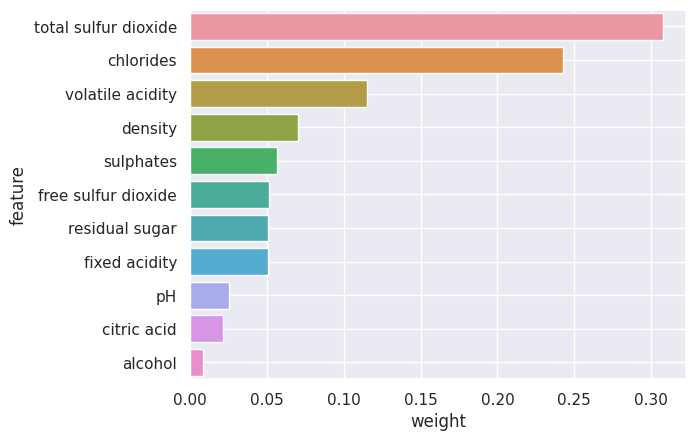

In [ ]:
_ = pd.DataFrame({
    'feature' : X_train.columns,
    'weight' : model.feature_importances_
    }).sort_values(by='weight', ascending=False).reset_index(drop=True)
sns.barplot(x=_.weight, y=_.feature).grid('both')

The model seems to be indicating that two, or possibly three, features seem to dominate the distinction between red and white wines:
* total sulfur dioxide
* chlorides
* volatile acidity

Looking at a pairwise plot for these three features yields:

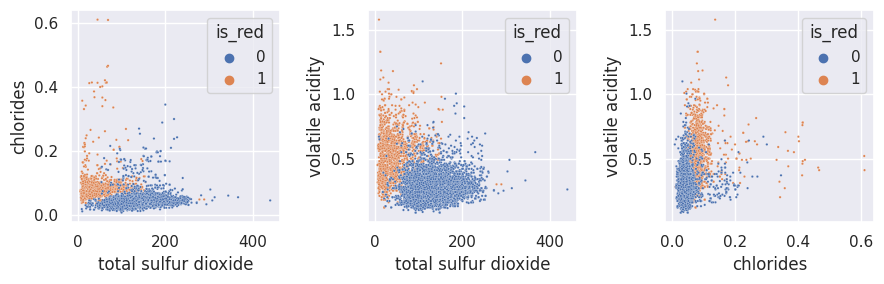

In [ ]:
f1 = 'total sulfur dioxide'
f2 = 'chlorides'
f3 = 'volatile acidity'
fig, ax = plt.subplots( 1, 3, figsize=(9,3))
sns.scatterplot( ax=ax[0], data=df_wines, x=f1, y=f2, hue='is_red', s=3)
sns.scatterplot( ax=ax[1], data=df_wines, x=f1, y=f3, hue='is_red', s=3)
sns.scatterplot( ax=ax[2], data=df_wines, x=f2, y=f3, hue='is_red', s=3)
plt.tight_layout();

These diagrams reveal a clear clustering for the bulk of the wines, indicating that white wines are higher in total sulfur dioxide, lower in chlorides, and lower in volatile acidity than white wines. There is, granted, an area of overlap between whites and reds, and there are some scattered outliers.

<a id='rvw_feature_importance_why'></a>
## Why Are These Features Important?
### Total Sulfur Dioxide
Sulfur dioxide is an important additive to wines where it [acts as a preservative][1], working as both an antioxidant and an antimicrobial. It is present in wine in both a free and bound form. The free form is available to act as the preservative; however, once bound, it is no longer available for this purpose.  The total sulfur dioxide is simply the sum of the free and bound forms.

The basic difference between a red and a white wine [lies in the grape skins][2]. When producing a white wine, the grape skins are removed from the pulp prior to fermentation, while for red wines they are left in.  It turns out that the grape skins contain tannin, and [tannin is a natural antimicrobial][3]. As a result, [red wines typically need less sulfur dioxide][4].

### Chlorides
Chlorides is simply a way of measuring [the salt content in a wine][5]. Salt is naturally present in grapes, though the amount can vary depending upon the [geological and climatic conditions of the vineyard][6]. It turns out, though, that the fermentation process also affects the chloride content.  The skins of the grapes contain chloride ions; leaving the skins in the pulp during the fermantation process (as is done with red wines) can [increase chloride concentration in the wine by 70%][5].

### Volatile Acidity
Volatile acidity is a [measure of the gaseous acids in a wine][7], and is often considered to be an indicator of the spoilage.  By law, red wines are allowed a higher volatile acidity than whites. Why? We do not know, nor have we found a clear explanation of the difference seen in reds and whites. Some hints we have found center around statements that
* high volatile acidity may imply insufficient use of sulfur dioxides
* for some wines, the aromas associated with a volatile acids are considered part of the appeal
* [natural wines][8] may be more more succeptible to high volatile acidity.

It may be that a sharper smell is more appealing on a red wine than a white. It also may be that red wines rely more on the natural antimicrobials of tannin and thus may not have sufficient sulfur dioxide to stave off the volatile acidity. This, however, is obviously just an ill-informed conjecture; we would be thrilled if someone could provide us with a legitimate explanation for tendency of red wines to have higher volatile acidity than whites.

[1]:https://store.extension.iastate.edu/Product/16425-pdf
[2]:https://corkdining.com/wine-series/white-wine-vs-red-wine-whats-the-difference/
[3]:https://www.tannins.org/the-antimicrobial-activity-of-tannins/
[4]:https://grape-to-glass.com/index.php/sulphur-levels-wine/
[5]:https://www.awri.com.au/wp-content/uploads/2018/08/s1530.pdf
[6]:https://www.oiv.int/standards/compendium-of-international-methods-of-wine-and-must-analysis/annex-d/annex-d-advices/level-of-sodium-and-chlorides-ions-in-wines
[7]:https://www.wineenthusiast.com/basics/drinks-terms-defined/volatile-acidity-wine/
[8]:https://vinepair.com/articles/volatile-acidity-wine/

<a id='rvw_simplified'></a>
## Simplifying the Model
With the data on the red and white wines being so well clustered, it is natural to wonder how many features are actually needed to build a reliable model for discerning between red and white wines. We can explore this question by using the three most important features just indentified, and build a series of models by including those features one-by-one in order of importance.

In [ ]:
features = []
for feature in [f1, f2, f3]:
    features.append(feature)
    X = df_wines[features]
    y = df_wines.is_red
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    model = RandomForestClassifier()
    model.fit( X_train, y_train)
    score = model.score(X_test, y_test)

    print( "Score: {} for Features: {}".format( score, ", ".join(features)))

Score: 0.9126153846153846 for Features: total sulfur dioxide
Score: 0.9790769230769231 for Features: total sulfur dioxide, chlorides
Score: 0.9864615384615385 for Features: total sulfur dioxide, chlorides, volatile acidity


From a single feature, ```total sulfur dioxide```, one already has enough predictive power to correctly identify a wine's color 91% of the time!  Adding in a second feature, ```chlorides``` jumps the predictive power to approximately 98%.

<a id='qp'></a>
# Quality Prediction
We now turn to trying to employing machine learning models for predicting the quality of a wine based upon the recorded physicochemical properties. Others who have analyzed this dataset have chosen to work with the reds and whites separately rather than applying a machine learning model on the combined dataset; we will follow suit.

There are a couple of reasons behind our decision to treat reds and whites separately.  First, as we saw in the previous section, there are physicochemical differences between reds and whites.  As such, a measurement which is spot on for a good red wine may, in fact, be undesirable for a white. To attain the greatest predictivity of ```quality```, it seems reasonable to separate known differences and instead focus on the comparison of likes to likes. Second, however, is the more compelling reason; human taste is involved in the determination of ```quality```. Some people prefer whites; others prefer reds. Whites are good with fish; reds are good with beef. The qualities/properties one desires in a white are different from those in a red. As the ```quality``` of a wine presumably reflects how well the wine achieves its desired properties,  it would seem as if the ```quality``` scale naturally differs between reds and whites.

<a id='qp_reg_vs_class'></a>
## Regression vs Classification

The ```quality``` parameter that we are trying to predict is an ordinal - an ordered categorical. An ordinal is a type of categorical; however, they do lie somewhat [in-between a categorical and a quantitative (continuous) variable][1] due to the ordering aspect. In fact, an ordinal can [often times be treated as a continuous variable][2], from a statistical viewpoint.

This apparent ambiguity immediately raises the question of whether one should use a classification or a regression model for predicting ```quality```.  To examine this, we will run a quick experiment a RandomForest model to compare regression and classification.

[1]:https://www.simplilearn.com/what-is-ordinal-data-article
[2]:https://www.frontiersin.org/articles/10.3389/feduc.2020.589965/full

In [ ]:
X = df_whites.drop(columns='quality')
y = df_whites.quality
X_train, X_test, y_train, y_test = train_test_split( X, y)

model_1 = RandomForestClassifier()
model_1.fit( X_train, y_train)

model_2 = RandomForestRegressor()
model_2.fit( X_train, y_train)

print("Classification Score: ", model_1.score(X_test, y_test) )
print("Regression  Score: ", model_2.score(X_test, y_test) )

Classification Score:  0.6579591836734694
Regression  Score:  0.5176262500000002


<a id='qp_issues_metric'></a>
### Issues with the Metric
This result seems to come solidly in factor of classification.  On closer examination, however, it appears that this conclusion may be based on an overly naive comparison. Our first criticism here is that the metric used for scoring the regression test is simply wrong. To see this, let's examine the first few predictions made by both models.

In [ ]:
pd.DataFrame({
    'actual' : y_test[:10],
    'classification' : model_1.predict(X_test)[:10],
    'regression' : model_2.predict(X_test)[:10]
    })

,actual,classification,regression
3906,7,7,7.06
4074,4,5,5.34
3536,6,6,6.04
751,6,6,5.96
4391,5,6,5.50
3503,7,7,6.61
3786,5,5,5.34
3164,6,6,5.98
2995,6,6,6.55
1149,5,6,5.48


Given that ```quality``` is an ordinal, a regression model's prediction of, say, ```quality```=5.19 should probably be interpretted as a prediction of ```quality```=5 prior to scoring. That deviation of 0.19 has meaning in the metric employed by the scoring in the regression model; but, it is a false reality.

With the limited sample above, the classification and regression models would score the same if one were to first round the regression results prior to scoring. In fact, when we apply this rounding approach to the entire set of predictions from the regression model, the results from the classification and regression approaches are virtually identical.

In [ ]:
rounded_score = lambda x,y : (np.rint(x)==y).sum() / len(x)
print("Classification Score: ", model_1.score(X_test, y_test) )
print("Regression  Score: ", rounded_score( model_2.predict(X_test), y_test) )

Classification Score:  0.6579591836734694
Regression  Score:  0.673469387755102


<a id='qp_issues_scoring'></a>
### Issues with the Scoring
Our second criticism is with the scoring process itself and what it is deemed *a successful prediction*. Our concern starts with simply wondering about the quality of the scores being reported - a measly 66%. The RandomForest method is getting this right only two out of three times - how can it be so bad?

We suspect that part of the issue lies with the scoring methodolgy itself, which treats a miss as being as good as a mile.  For example, imagine a scenario where a wine critic gave the a wine as being an 8 for quality, while the RandomForesetClassifier predicted the value of 7.4 for the quality.  According to the scoring methodology, this would be deemed as a failure of the model to predict the quality. Not only that, this failure is ***deemed to be just as bad*** as if the model predicted a quality of 3 for the wine.

If this was, in fact, the cause of the poor scores, it would seem as if the problem was with the scoring methodolgy rather than with the modelling, and that the proper response would be to develop a better investigate ways of improving the scoring methodlogy.

In any case, a simple way to investigate this question is to introduce a slight generalization to the success criterion used in scoring. We will focus on the regression model and note that a prediction is deemed successful if the predicted ```quality``` falls within a window of 0.5 of the actual ```quality```.  the current criterion for success is to see if the predicted ```quality``` is within a window of 0.5 of the actual ```quality```.  If the scoring methdology itself is the issue, we would expect that using a slightly larger window could by manifested with a significantly better score.

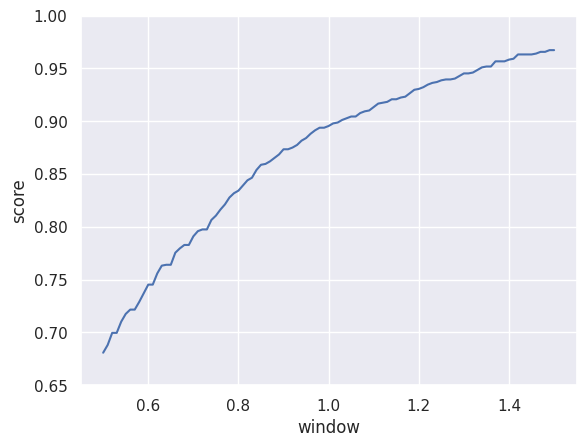

In [ ]:
def score_within_window( actual, predicted, delta):
    within = lambda x : abs(x) <= delta
    return (predicted - actual).apply( within ).sum() / len(predicted)


pred = model_2.predict( X_test )
incr = 0.01
windows = np.arange(0.5, 1.5 + incr, incr)
_ = pd.DataFrame({
    'window' : windows,
    'score' : [ score_within_window( y_test, pred, window) for window in windows]
    })
sns.lineplot( data=_, x='window', y='score')
plt.ylim(0.65,1);

This seems to confirm our suspicion. With this in hand, we will proceed by investigating ***regression models*** with a ***suitably chosen window size*** for scoring.

The obvious next question would be, '*What qualifies as a suitably chosen window size?*'  While the selection is somewhat arbitrary, we feel that using a ***window of 1*** is reasonable. That this basically means is that a predicted ```quantity``` that lies somewhere between 5 and 6, say, would be deemed a success only if the actual ```quantity``` was either 5 or 6.

Note that with this approach, the *RandomForestClassifier* would score 0.9 - meaning that it was accurate 90% of the time. And that seems much more reasonable.

<a id="qp_prep"></a>
## Dataset Preparation

The datasets for the red and white wines consist of a set of continuous features in addition to ```quality``` target. This makes much of the initial preparation ahead of applying a machine learning model trivial - simply scale the continuous features, using a [standardization][1] method. We do so in the following, where we have taken the extra step of converting the scaled data from the [numpy ndarray][2] returned by the [sklearn scaling utilities][3] to a [pandas dataframe][4], simply because we find ndarrays clumsy to work with and it is convenient to retain the column headings at this stage of the analysis. We would like to point out that we have used the standard practice scaling was based soley on the *training* data in order to prevent the leakage of *test* data into the fitting of a model.

[1]:https://www.shiksha.com/online-courses/articles/normalization-and-standardization/
[2]:https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html
[3]:https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
[4]:https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
[5]:https://stats.oarc.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-interval-variables/

In [ ]:
class WineDataSet():
    def __init__( self, df, random_state=42, scaler=None):
        X = df.drop( columns='quality')
        y = df.quality
        X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=random_state)

        if scaler:
            scaler.fit(X_train)
            X_train = pd.DataFrame( scaler.transform(X_train), columns=X.columns)
            X_test = pd.DataFrame( scaler.transform(X_test), columns=X.columns)

        self.df = df
        self.X_raw = X
        self.y_raw = y
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

w = WineDataSet( df_whites, scaler=StandardScaler() )
r = WineDataSet( df_reds, scaler=StandardScaler() )

<a id='qp_dof'></a>
## Effective Degrees of Freedom
Before applying a machine learning model, we would like to investigate whether the recorded physicochemical features are truly independent. Do any of the features appear to be simply a combination of others?  To be slightly more precise (since feature engineering often involves synthesizing new features that are non-linear functions of existing features), do the features suffer from [multicollinearity][1]?

A standard approach for uncovering multicollinearity is to employ a *[variance inflation factor (VIF)][2]* analysis. A nice description of VIF has been presented by kaggler [Carl McBride Ellis][3].  The process is quite straightforward
* run the the various features, calculating the variance_inflation_factor with the aid of statsmodels
* look for features whose VIF seems unusually large (often times defined as being greater than 5)
* consider removing said features prior to fitting with a model

NOTE: the code below takes an additional step of using the statsmodels ```add_constant``` prior to invoking ```variance_inflation_factor```, [on the advice of the author][4] of said function.  While this step is not necessary in our particular application (as our scaling involves standardization, thus centering the data at zero rather than leaving it at an offset), including this step seemed like good form.

[1]:https://en.wikipedia.org/wiki/Multicollinearity
[2]:https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
[3]:https://www.kaggle.com/code/carlmcbrideellis/variance-inflation-factor-vif-and-explainability
[4]:https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calc_vif( X ):
    vif = pd.DataFrame()
    X = add_constant(X)
    vif['features'] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif.query( 'features != "const"')

pd.merge(
    calc_vif(w.X_train).rename(columns={'VIF' : 'whites'}),
    calc_vif(r.X_train).rename(columns={'VIF' : 'reds'}),
    on='features',
    how='outer'
    )

,features,whites,reds
0,fixed acidity,2.645569,7.255800
1,volatile acidity,1.135478,1.803109
2,citric acid,1.169698,3.163694
3,residual sugar,12.198058,1.712743
4,chlorides,1.225773,1.509046
5,free sulfur dioxide,1.781568,1.967686
6,total sulfur dioxide,2.216279,2.198929
7,density,26.269737,5.890908
8,pH,2.143359,3.242698
9,sulphates,1.138172,1.444976


This is interesting. There is a signficant difference between the whites and the reds.  With the whites, ```density``` has an extraordinarily large VIF, whereas for the reds the VIF peaks with ```fixed acidity```.  Rerunning the calculation with those those features removed from their respective dataset yields a much more well-behaved result.

In [ ]:
pd.merge(
    calc_vif(w.X_train.drop(columns='density')).rename(columns={'VIF' : 'whites'}),
    calc_vif(r.X_train.drop(columns='fixed acidity')).rename(columns={'VIF' : 'reds'}),
    on='features',
    how='outer'
    )

,features,whites,reds
0,fixed acidity,1.369300,NaN
1,volatile acidity,1.117762,1.795139
2,citric acid,1.164753,2.799778
3,residual sugar,1.437538,1.365528
4,chlorides,1.193414,1.432894
5,free sulfur dioxide,1.742201,1.940484
6,total sulfur dioxide,2.144442,2.079482
7,pH,1.334290,1.601275
8,sulphates,1.055724,1.402499
9,alcohol,1.644730,2.086734


<a id='qp_models_p1'></a>
## Models Phase One - Algorithm Selection

Next, we need to select which machine learning algorithm to employ. As this is a fairly small dataset, we will start with a brute force approach of simply running through a set of algorithms to see which seems to do the best "out-of-the-box" (i.e., untuned).

*Note: despite what we learned in the previous section, we do not yet want to remove any features. Our basic thought here is that while it makes sense avoid multicolinearity for linear models, it is not yet clear that we will settle on a linear model.*

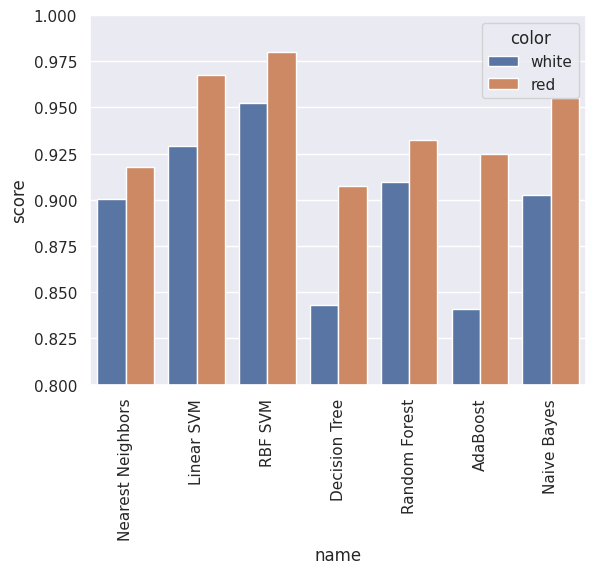

In [ ]:
WINDOW_SIZE = 1
def apply_algo( name, model, dataset):
    model.fit( dataset.X_train, dataset.y_train)
    predict = model.predict( dataset.X_test )
    score = score_within_window( predict, dataset.y_test, WINDOW_SIZE)
    return { 'name':name, 'score':score}

algos = [
    ( "Nearest Neighbors", KNeighborsRegressor() ),
    ( "Linear SVM", SVC(kernel="linear")),
    ( "RBF SVM", SVC() ),
    ( "Decision Tree", DecisionTreeRegressor(max_depth=5) ),
    ( "Random Forest", RandomForestRegressor() ),
    ( "AdaBoost",AdaBoostRegressor() ),
    ( "Naive Bayes",GaussianNB() )
    ]

whites = [ apply_algo( name, model, w) for name, model in algos]
reds = [ apply_algo( name, model, r) for name, model in algos]

_ = pd.concat([
        pd.DataFrame( whites ).assign(color='white'),
        pd.DataFrame( reds ).assign(color='red'),
        ])
sns.barplot( data=_, x='name', y='score', hue='color')
plt.xticks(rotation=90)
plt.ylim(0.8,1.0);

All of the models appear to be doing quite at predicting the quality of the wine, with the *Support Vector Machine* models being the clear winners.  In particular, the use of the *Radial Basis Function (RBF)* kernel yields outstanding results.

For some reason, all of the models seem to do slightly better are predicting the quality of the red wines. We found this odd, as the whites dataset is 3 times larger than that of the reds. One normally might expect that training with a larger dataset would be statistically more significant, and thus may do a better job with predictions. It is certainly possible, however, that there is a larger natural variation amongst white wines than there is with reds, and this may be what the above results are hinting at.

In [ ]:
useless = ['fixed acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'pH', 'sulphates', 'density']
model = SVC()
model.fit( w.X_train.drop(columns=useless), w.y_train)
pred = model.predict( X_test.drop(columns=useless))
score_within_window( pred, w.y_test, WINDOW_SIZE)

0.9330612244897959

<a id='qp_models_p2'></a>
## Models Phase Two - Feature Importance
We will now focus on the *Support Vector Machine* with the RBF kernel as its predictions seem to be the most accurate. The next natural set of questions lie around **feature importance**. Which features seem to be the most important for model? Does the answer for whites differ from those for reds? Furthermore, are there any features that appear to provide little value - i.e., are there opportunities for a reduction of dimensionality?

One common approach to these questions is to employ [permutation importance][1]. This is a clever technique in which one sees the impact on a score by randomly shuffling the values of a feature. If the feature is important, the shuffling will cause the predictive power of the model to degrade; if the feature is irrelevant, the shuffling will have little impact on the score. Dan Becker provided a nice explanation of permuation importance in his course [Machine Learning Explanability][2].

[1]:https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
[2]:https://www.kaggle.com/learn/machine-learning-explainability

In [ ]:
def scorer( model, X, y):
    return score_within_window( model.predict(X), y, WINDOW_SIZE)

def display_feature_importance( df, model):
    model.fit( df.X_train, df.y_train)
    imp = permutation_importance( model, w.X_test, w.y_test, scoring = scorer)

    features = df.X_test.columns
    mean = imp['importances_mean']
    stdev = imp['importances_std']
    sns.barplot( x = mean, y=features)
    plt.errorbar(  x = mean, y=features, xerr = stdev, fmt='None', c= 'black', capsize = 2)

<a id="qp_dr_whites"></a>
### Dimensionality Reduction - Whites
Let's first look at the white wines and see which features appear to have permutation importance.

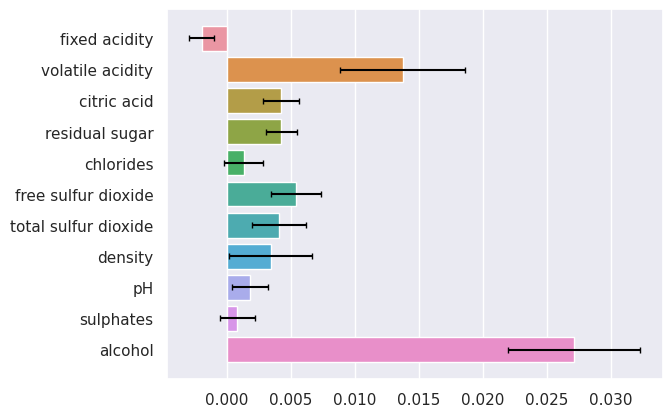

In [ ]:
display_feature_importance( w, SVC() )

From this graph, it appears that
* two features, ```alcohol``` and ```volatile acidity```, strongly influence the score
* one feature, ```free sulfur dioxide```, has a moderate impact
* three features, ```fixed acidity```, ```total sulfur dioxide```, and ```sulphates``` may be irrelevant (error bars crossed 0)
* the remaining features have small impact

NOTE that the mean for ```fixed acidity``` was negative. Dan Becker's article specifically discussed this possibility, indicating that the 'noise' introduced by the shuffling appeared to make the model *more* predictive - but that this basically attested to the irrelevancy of the feature.

This result offers hope for dimensionality reduction. At a bare minimum, we should try removing the three possibly irrelevant feature and see how the reduced model fares.

In [ ]:
features = w.X_test.columns.drop(['fixed acidity','total sulfur dioxide','sulphates'])
model = SVC()
model.fit(w.X_train[features], w.y_train)
pred = model.predict( w.X_test[features] )
score_within_window( pred, w.y_test, WINDOW_SIZE)

0.9567346938775511

That's fantastic! The score is virtually unchanged despite the removal of three features!

Let's push this a bit further and remove every feature that appeared to have little to no impact (from the permutation_importance analysis), leaving us with simply three features.

In [ ]:
features = ['volatile acidity', 'free sulfur dioxide', 'alcohol']
model.fit(w.X_train[features], w.y_train)
pred = model.predict( w.X_test[features] )
score_within_window( pred, w.y_test, WINDOW_SIZE)

0.9493877551020408

Honestly, we found this to be a stunning result.  Limiting the features to just the three most important did come with a cost of a ***minor*** degradation of the score. However, the score that remained was still extremely good.

<a id="qp_dr_reds"></a>
### Dimensionality Reduction - Reds
Next, perform a similar analysis on the red wines.

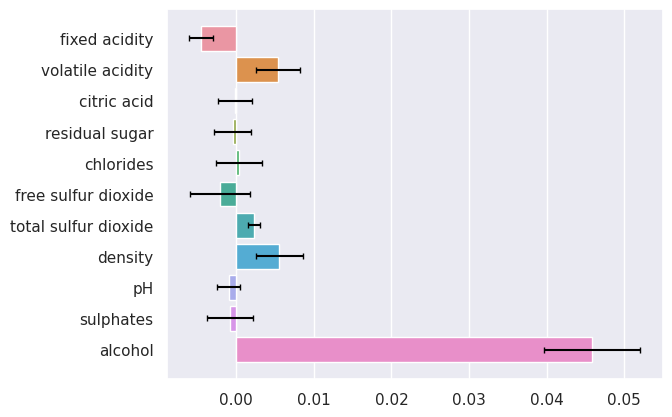

In [ ]:
display_feature_importance(r, SVC())

The red wines seem even simpler than the whites
* one feature ```alchohol```, has a strong impact
* one feature, ```density```, has a moderate impact
* one feature, ```total sulfur dioxide```, has a small impact
* the remaining features appear to be irrelevant

Experience with the whites taught us to ignore the feature with little to no impact. That leaves us with just ***two*** features, ```alcohol``` and ```density```.

In [ ]:
features = ['density', 'alcohol']
model.fit(r.X_train[features], r.y_train)
pred = model.predict( r.X_test[features] )
score_within_window( pred, r.y_test, WINDOW_SIZE)

0.9525

Again, limiting the feature set to just those with moderate to large impact appears to result in an ever so slight degredation in score. But, the score that remained even with the vastly reduced model was still extremely good.